# FreeCat
FreeCat is a concatenative synthesizer connected to Freesound. This notebook is a prototype implementation in python.

## Setup

Install Essentia and Freesound python client.

In [1]:
%%capture
# Essentia
!pip install essentia
# Freesound-python
!git clone https://github.com/MTG/freesound-python.git
%cd freesound-python
!python setup.py install
# Come back to root directory
%cd ..

Import needed dependencies.

In [2]:
import os
import pandas as pd
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt
import freesound
import essentia.standard as ess
from sklearn.decomposition import PCA
from IPython.display import display, Audio
from tqdm import tqdm
from scipy.interpolate import griddata
from sklearn.preprocessing import StandardScaler

Set some global configurations.

In [3]:
FREESOUND_API_KEY = 'M7lHLqRJs0jWdIp9b4jVLnhyFoG3MciqO2Tv3ku3'  # Personal Freesound API key
FILES_DIR = 'files'  # Folder to store the downloaded files. Will be relative to the current folder.
FREESOUND_METADATA_FIELDS = ['id', 'name', 'username', 'previews', 'license', 'tags', 'analysis', 'analysis_frames']  # Freesound metadata properties to store
FREESOUND_METADATA_FILTER = 'duration:[0.5 TO 5]'
FREESOUND_METADATA_DESCRIPTORS = ['lowlevel.mfcc.mean', 'lowlevel.mfcc.var', 'lowlevel.average_loudness']
grain_size = 4410 # 100 ms in samples (fs=44100)

annotation = True # boolean that determines if sound IDs get represented in plots
freesound_client = freesound.FreesoundClient()
freesound_client.set_token(FREESOUND_API_KEY)
if not os.path.exists(FILES_DIR): os.mkdir(FILES_DIR)

### Util functions 
Used in next sections.

##### Corpus creation

In [4]:
## Corpus creation
def query_freesound(query, num_results=1):
    """Queries freesound with the given query and filter values.
    It requests the specified analysis descriptors of each sound.
    """
    pager = freesound_client.text_search(
        query = query,
        filter = FREESOUND_METADATA_FILTER,
        fields = ','.join(FREESOUND_METADATA_FIELDS),
        descriptors = ','.join(FREESOUND_METADATA_DESCRIPTORS),
        page_size = num_results
    )
    return [sound for sound in pager]

def retrieve_sound_preview(sound, directory):
    """Download the high-quality (compared to the MP3 preview) OGG 
    sound preview of a given Freesound sound object to the given directory.
    """
    return freesound.FSRequest.retrieve(
        sound.previews.preview_hq_ogg,
        freesound_client,
        os.path.join(directory, sound.previews.preview_hq_ogg.split('/')[-1])
    )

def get_sounds_by_ID(ids_list):
    """ Given a list of sound IDs from Freesound, it returns a list of sound 
    objects with the specified fields and descriptors.
    """
    sounds = []
    for id in ids_list:
        sound = freesound_client.get_sound(
            id,
            fields = ','.join(FREESOUND_METADATA_FIELDS),
            descriptors = ','.join(FREESOUND_METADATA_DESCRIPTORS)
        )
        sounds.append(sound)
    return sounds

def grid_interpolation(ref_sounds, nx, ny):
    # MFCC coefficients of the reference sounds
    known_values = np.asarray([sound.analysis.lowlevel.mfcc.mean for sound in ref_sounds])
    # Fixed positions of the reference sounds on the corners of the quadrilateral
    known_points = np.array([(1, 0),(1, 1),(0, 0),(0, 1)]) 

    # Build grid of (nx,ny) points
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    xv, yv = np.meshgrid(x, y)
    xv = xv.flatten()
    yv = yv.flatten()
    grid = []
    interp_points = []
    for i in range(len(xv)):
        grid.append([xv[i], yv[i]])
        # The interpolation points should not include the corners themselves
        if xv[i]==known_points[0][0] and yv[i]==known_points[0][1] \
          or xv[i]==known_points[1][0] and yv[i]==known_points[1][1] \
          or xv[i]==known_points[2][0] and yv[i]==known_points[2][1] \
          or xv[i]==known_points[3][0] and yv[i]==known_points[3][1]:
            continue
        else:
          interp_points.append([xv[i], yv[i]])

    # Make the interpolation
    interp_values = griddata(known_points, known_values, np.asarray(interp_points), method='linear', fill_value=0)
    return interp_values, grid

def get_sounds_by_MFCCs(mfccs_array, avoid_sounds):
    """ Performs a content based search using MFCCs as targets – one result per search.
    :mfccs_array: arrays with MFCCs coefficients (13 coefficients per sound).
    :avoid_sounds: sounds that we don't want to get returned by the method.
    """
    sounds = []
    for mfccs in mfccs_array:
        mfccs_str = ','.join(map(str, mfccs.tolist()))
        pager = freesound_client.content_based_search(
            target = f'lowlevel.mfcc.mean:{mfccs_str}',
            filter = FREESOUND_METADATA_FILTER,
            fields = ','.join(FREESOUND_METADATA_FIELDS),
            descriptors = ','.join(FREESOUND_METADATA_DESCRIPTORS),
            page_size = 2
        )
        results = [sound for sound in pager]

        # Avoid getting the same sounds we are using as reference
        if results[0] in avoid_sounds:
            sounds.append(results[1])
        else:
            sounds.append(results[0])

    return ref_sounds + sounds

##### Feature extraction

In [38]:
## Feature extraction
def analyze_segments(audio, grain_size):
    
    if len(audio)<grain_size:
        segment_start_end_samples = [(0,len(audio))]
    else:
      # Calculate the start and end samples for each equally-spaced audio segment
      segment_start_samples = range(0, len(audio), grain_size)
      segment_start_end_samples = zip(segment_start_samples[:-1], segment_start_samples[1:])

    # Iterate over audio frames and analyze each one
    analysis = pd.DataFrame(columns=['start_sample', 'end_sample','loudness'])
    for i, (start, end) in enumerate(segment_start_end_samples):
        # Get corresponding audio segment
        grain = audio[start:end]

        # Extract loudness
        loudness = ess.Loudness()(grain)/grain_size
        loudness_dB = 10*np.log10(loudness)

        # Add analysis results to output dataframe
        analysis.loc[i] = [start, end, loudness_dB]

    return analysis

def get_audios_and_analysis(sounds, grain_size):
    """ Load all available analysis and audios into a dataframe.
    """
    df = pd.DataFrame(columns=['sound_id', 'audio','average_loudness','grain_analysis','mfccs_mean', 'loudness_FS','mfcss_normalized','pca', 'pca_norm_range'])
    feats = []
    i = 0
    for sound in sounds:
        if sound.analysis:
            file_path = os.path.join(FILES_DIR, sound.previews.preview_hq_ogg.split('/')[-1])
            # Load audio
            audio = ess.MonoLoader(filename=file_path)()
            # Calculate loudness - in logaritmic scale and normalized
            average_loudness = 10*np.log10(ess.Loudness()(audio)/len(audio))
            # Divide the audio in fixed-size grains and analyze them
            grain_analysis = analyze_segments(audio, grain_size)

            # Get Essentia's Freesound extractor precomputed features
            mfcc_mean = sound.analysis.lowlevel.mfcc.mean
            loudness_FS = sound.analysis.lowlevel.average_loudness
            # Store them in a dataframe
            df.loc[i] = [sound.id, audio, average_loudness, grain_analysis, mfcc_mean, 10*np.log10(loudness_FS), 0, 0, 0]
            feats.append(mfcc_mean)
            i += 1
        else:
            print(f'Sound {sound.id} skipped because the analysis is not available.')

    # Normalize features - make features look like standard normally 
    # distributed data, as PCA maximizes the variance and can be fooled by different scales
    mfcss_norm = StandardScaler().fit_transform(feats)
    for i, feat in enumerate(mfcss_norm):
        df['mfcss_normalized'].loc[i] = feat
    
    # Dimensionality reduction - Principal Components Analysis
    pca = PCA(n_components=2).fit_transform(mfcss_norm)
    # add it to the existing df
    for i, tuple in enumerate(pca):
        df['pca'].loc[i] = tuple

    # Normalize to have coordinates in a range of 
    max_value = np.max(np.max(np.array(pca)))
    print("Max value of all PCAs:", max_value)
    for i, tuple in enumerate(pca):
        # Normalize by max value and put in the range of 0-1
        df['pca_norm_range'].loc[i] = (np.asarray(tuple)/max_value + 1)/2
    
    print(f'\nTotal number of sounds used at the end: {len(df.index)}')
    return df

##### Sound segmentation

In [6]:
## Sound segmentation
def get_audio_segment(sound_id, df, window='rectangular'):
    """ Take an n_samples long segment of a given audio and window it.
    If no start_sample is provided, take a random one.
    """
    # Get the average loudness and the loudness of each grain of this audio
    target_loudness = df.loc[df['sound_id']==sound_id]['average_loudness'].values[0]
    df_grains = df.loc[df['sound_id']==sound_id]['grain_analysis'].values[0]

    # Get the grains that are inside a certain margin
    filter = (df_grains['loudness'] >= target_loudness-6) & (df_grains['loudness'] <= target_loudness+6)
    possible_starting_samples = df_grains.loc[filter]['start_sample'].values
    if possible_starting_samples.size != 0:
        # Make a random choice between the grains inside the loudness margin
        start_sample = int(np.random.choice(possible_starting_samples))
        end_sample = int(df_grains.loc[df_grains['start_sample']==start_sample]['end_sample'].values[0])
    else:
        # When not possible, take a totally random sample
        print(df_grains['start_sample'].values)
        start_sample = int(np.random.choice(df_grains['start_sample'].values))
        end_sample = int(df_grains.loc[df_grains['start_sample']==start_sample]['end_sample'].values[0])

    # Time window for the segment
    w = get_window(window, end_sample-start_sample)   
    # Get audio and segment it
    audio = df.loc[df['sound_id']==sound_id]['audio'].values[0]
    segment = audio[start_sample:end_sample]*w 

    return segment

def overlap_add(first_audio, second_audio, N=None):
    """ Overlaps N samples of two audio chunks.
    """
    if N is None:
        N = int(np.floor(len(first_audio)/2))
    M = len(first_audio)+len(second_audio)-N
    result = np.zeros(M)

    if N == 0: # no overlapping at all
        result = np.concatenate((first_audio, second_audio))
    else:
        result[:len(first_audio)-N] = first_audio[:-N]
        result[len(first_audio)-N:len(first_audio)] = first_audio[-N:]+second_audio[:N]
        result[len(first_audio):] = second_audio[N:]

    return result

##### Unit selection

In [47]:
## Unit selection
def compute_distance(p1, p2):
    return np.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )

def get_closest_sound(click, df):
    """ Get the closest sound to the coordinates of a mouse click. It returns the sound ID.
    Brute force linear search.
    """
    shortest_distance = None
    shortest_distance_sound = None

    for idx, row in df.iterrows():
        if content_based_search:
            distance = compute_distance(click, row['grid'])
        else:
            distance = compute_distance(click, row['pca_norm_range'])
        if shortest_distance is None or distance < shortest_distance:
            shortest_distance = distance
            shortest_distance_sound = row['sound_id']

    return shortest_distance_sound

## Corpus creation
A selection of sounds is downloaded from Freesound. Number of sounds considered dense enough: 25 (arbitrary).
Select one of the two methods to create the corpus:

1) Text query: Make a text query and download the first 25 results.

2) Interpolation + content-based search: choose four sounds (four corners of the map), interpolate MFCCs between them and download the sounds that are close to these coefficients using content-based search.

#### Text query

In [ ]:
# Make a text query and get 30 results
query='frog'
sounds = query_freesound(query, num_results=25)
# Download the ogg previews
for count, sound in enumerate(sounds):
    print('Downloading sound with id {0} [{1}/{2}]'.format(sound.id, count + 1, len(sounds)))
    retrieve_sound_preview(sound, FILES_DIR)

# Aux boolean for plotting
content_based_search = False

#### Interpolation + content-based search

In [45]:
# Four sounds + interpolation + content based search
sound_top_left = '357589' # Trumpet - Asharp3
sound_top_right = '328727' #  flute_note_tremolo
sound_bottom_left = '255805' # male voice
sound_bottom_right = '344270' # glass smash, bottle, G
ref_ids_list = [sound_top_left, sound_top_right, sound_bottom_left, sound_bottom_right]
# total number of sounds (including reference sounds): nx*ny
nx = 5
ny = 5

# Get these four reference sounds and their MFCCs
ref_sounds = get_sounds_by_ID(ref_ids_list)

# Interpolation of intermediate MFCCs
interp_values, grid = grid_interpolation(ref_sounds, nx, ny)

# Content based search using MFCCs as targets
sounds = get_sounds_by_MFCCs(interp_values, ref_sounds)

# Download the ogg previews
for count, sound in enumerate(sounds):
    print('Downloading sound with id {0} [{1}/{2}]'.format(sound.id, count + 1, len(sounds)))
    retrieve_sound_preview(sound, FILES_DIR)

# Aux boolean for plotting
content_based_search = True

## Feature extraction
Sounds are analyzed to extract specific audio features and plot the sounds according to these features. 
- MFCCs (from analysis in FS) + PCA
- 4 chosen sounds + grid interpolation of the the MFCCs (from analysis in FS)

In [46]:
df = get_audios_and_analysis(sounds, grain_size)
if content_based_search:
    df['grid'] = grid
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Max value of all PCAs: 5.783629985511752

Total number of sounds used at the end: 25


,sound_id,audio,average_loudness,grain_analysis,mfccs_mean,loudness_FS,mfcss_normalized,pca,pca_norm_range,grid
0,357589,"[-1.2636276e-05, -3.3100736e-05, -3.4930537e-0...",-34.268812,start_sample end_sample loudness 0 ...,"[-885.2243435450247, 111.38669547404292, -114....",-9.116989,"[1.4282335130251285, 0.7919833463190157, -1.95...","[-2.5328859751187993, 1.8500310436573644]","[0.28102973552390187, 0.6599368431496978]","[0.0, 0.0]"
1,328727,"[-8.308648e-06, 3.445508e-05, -3.83804e-05, 1....",-37.303973,start_sample end_sample loudness 0 ...,"[-955.3650985406996, 121.42278697407917, -43.1...",-2.765639,"[-0.6878710919460261, 1.0708625047624543, -0.2...","[-5.023133029663311, -0.881009842986504]","[0.06574564397735666, 0.4238359088329066]","[0.25, 0.0]"
2,255805,"[-1.069195e-05, -8.387396e-06, 1.9174913e-06, ...",-29.092150,start_sample end_sample loudness 0 ...,"[-932.3183687030422, 119.03648993200034, 38.15...",-35.368572,"[0.007434955757625636, 1.0045529747139679, 1.7...","[5.783629985511752, 1.0718457438645432]","[1.0, 0.5926620259724052]","[0.5, 0.0]"
3,344270,"[2.4335208e-05, -1.9713421e-05, 6.9983653e-06,...",-29.383524,start_sample end_sample loudness 0 ...,"[-945.3631355752407, 1.42696695573554, 9.34103...",-54.429303,"[-0.38611785459830067, -2.2635364794760946, 1....","[2.5598640913001334, -1.6288226981376228]","[0.7213025468185816, 0.3591868167381129]","[0.75, 0.0]"
4,462499,"[9.144165e-10, 1.8859868e-08, 2.9846635e-08, 1...",-49.108782,start_sample end_sample loudness 0 ...,"[-890.4942629436329, 117.24574154029946, -8.46...",-26.663038,"[1.2692431983655665, 0.9547923279064257, 0.621...","[3.2807859014938634, 1.933778226040055]","[0.7836268839563023, 0.6671768621855353]","[1.0, 0.0]"
5,105077,"[-0.0038976604, -0.0037086871, -0.003099543, -...",-38.463703,start_sample end_sample loudness 0 ...,"[-913.1616540050126, 93.42231500731536, -27.65...",-47.579843,"[0.5853815745403691, 0.2927958581917267, 0.154...","[1.844657803146417, 1.0318473300010644]","[0.6594723216878817, 0.5892041272164616]","[0.0, 0.25]"
6,342364,"[-7.875152e-06, 1.2419045e-05, 9.957717e-06, -...",-40.224371,start_sample end_sample loudness 0 ...,"[-978.3234366926999, 78.56009919056149, -69.15...",-12.492501,"[-1.3805104153882761, -0.12018983843789385, -0...","[-0.06953456431604749, -0.7628327605307186]","[0.49398867454434026, 0.4340524236127096]","[0.25, 0.25]"
7,13846,"[0.00076911633, 0.00023271143, 8.899308e-05, 0...",-46.678830,start_sample end_sample loudness 0 ...,"[-980.4807618014354, 87.21858122293412, 34.989...",-36.719407,"[-1.4455956229440898, 0.1204088231602983, 1.67...","[5.003277133195546, -0.7491074849227645]","[0.9325377959628275, 0.4352389860002013]","[0.5, 0.25]"
8,435740,"[8.584523e-11, -2.095983e-09, -7.791054e-09, -...",-40.111386,start_sample end_sample loudness 0 ...,"[-885.7610124220381, 94.39542052665132, -15.32...",-inf,"[1.412042534156098, 0.31983615055136666, 0.454...","[2.912633197699806, 1.5470390838539345]","[0.7517997524907438, 0.6337429164494734]","[0.75, 0.25]"
9,6552,"[1.1048871e-06, -4.7615248e-07, -6.0218764e-07...",-39.640962,start_sample end_sample loudness 0 ...,"[-878.2076056452868, 100.29544964333037, -30.6...",-19.524349,"[1.639924296542166, 0.483783953821723, 0.08178...","[1.0036014944680098, 1.6905025918259304]","[0.5867622493989135, 0.6461454653963613]","[1.0, 0.25]"


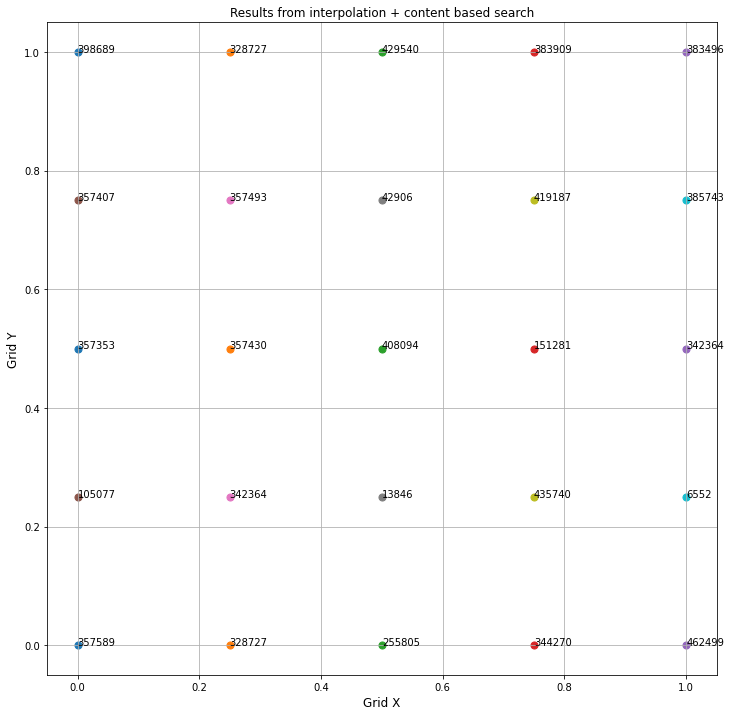

In [48]:
# Plotting
if not content_based_search:
    fig = plt.figure()
    fig.set_size_inches(12, 12, forward=True)
    plt.xlabel('Principal Component 1', fontsize = 12)
    plt.ylabel('Principal Component 2', fontsize = 12)
    plt.title('MFCCs – PCA')
    plt.grid()
    for idx, pca in enumerate(df['pca_norm_range']):
        plt.scatter(pca[0], pca[1], s = 50)
        if annotation:
          plt.annotate(sounds[idx].id, (pca[0],pca[1]))
else:
    fig = plt.figure()
    fig.set_size_inches(12, 12, forward=True)
    plt.xlabel('Grid X', fontsize = 12)
    plt.ylabel('Grid Y', fontsize = 12)
    plt.title('Results from interpolation + content based search')
    plt.grid()
        
    for i, tup in enumerate(grid):
        plt.scatter(tup[0], tup[1], s = 50)
        if annotation:
            plt.annotate(sounds[i].id, (tup[0], tup[1]))

## Unit selection
The unit selection is determined by the mouse's trajectory. To simulate this in a non-interactive way, an invented trajectory is created.
When the mouse stays in the same point (always selects the same sound), random segments of this sound are used.

In [56]:
## Implementation using last_buffered_sample
# simulated mouse clicks coordinates
trajectory = [[0, 0], [0, 0.2], [0, 0.4], [0, 0.7]] 
sim_time = [0, 1000, 2000, 3213] # "time" stamps when the mouse is clicked
total_time = 20 # fake total time in seconds
buffer_size = 256
window = 'triang' # type of window applied in the time domain to each segment

iterations = int((total_time*44100)/buffer_size)
last_buffered_sample = 0 # counter of the last sample buffered
last_segment = None # aux variable to save last loaded segment
click = None
output = np.array([]) # final audio (buffers concatenated)

# start "live" loop
for b in tqdm(range(iterations)):
    # 'clean' buffer
    buffer = np.zeros(buffer_size)

    # update mouse click (simulation)
    for idx, t in enumerate(sim_time):
        if b == t:
            click = trajectory[idx]
    
    # approximate mouse click to closest sound
    sound_id = get_closest_sound(click, df)

    # get segment of this sound – only when it is needed
    if last_segment is None or last_buffered_sample + buffer_size > len(last_segment):
        current_segment = get_audio_segment(sound_id, df, window=window)
        if last_segment is None:
            to_be_buffered = current_segment
        else:
            to_be_buffered = overlap_add(last_segment, current_segment, N=0) # no overlap happens if N=0
        last_buffered_sample = 0

    # fill the buffer
    buffer = to_be_buffered[last_buffered_sample:last_buffered_sample+buffer_size]
    last_buffered_sample += buffer_size
    last_segment = current_segment

    # send buffer to the 'output'
    output = np.concatenate((output, buffer))

100%|██████████| 3445/3445 [00:13<00:00, 249.23it/s]


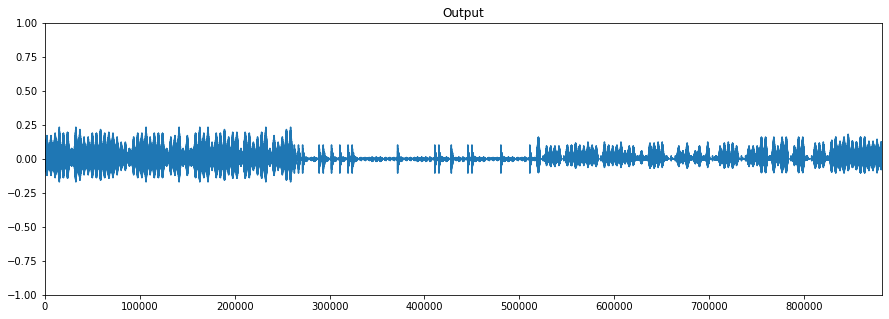

In [57]:
# Plot waveform
plt.figure(figsize=(15,5))
plt.plot(output)
plt.axis([0, len(output), -1, 1])
plt.title('Output')
plt.show()

# Show audio player
display(Audio(output, rate=44100))